In [13]:
#!pip install seaborn

In [9]:
import numpy as np
import pandas as pd
from mlxtend.plotting import plot_decision_regions
import random
from sklearn.tree import plot_tree
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt


In [10]:
import mlxtend
mlxtend.__version__

'0.23.3'

In [134]:
class AdaBoost(object):
    def __init__(self):
        pass
        
    def _train_classifier(self, X, y):
        """
        We will train decision stump, 1 depth tree  on data 
        """
        dt = DecisionTreeClassifier(max_depth=1)
        dt.fit(X,y)
        return dt.predict(X), dt
        
    def _calculate_model_weight_alpha(self,error):
        """
        # this is simple method which return alpha value from error
        # value, if error is greater , alpha is smaller and vice versa.
        # To understand this please refer to below plot at bottom of notebook
        """
        return 0.5 * np.log((1-error)/(error + 0.000001))

    def _get_alpha(self,df_, pred):
        """
        This method will first get all the examples of data where preicted label is not equal to 
        actual variable and sum up their weights which is called model error
        i.e sum of weights of mis classified examples
        After that it will get alpha value of classifier, alpha value is just defined as :- when error is small alpha is greater and
        vice versa from error value of 0 and 1
        """
        df_['y_pred'] = pred
        error =  df_.query("y != y_pred")['weights'].sum()
        alpha = self._calculate_model_weight_alpha(error)
        return alpha, error

    def _update_row_weights(self, row, alpha):

        if row['y'] == row['y_pred']:
            return row['weights'] * np.exp(-alpha)
        else:
            return row['weights'] * np.exp(alpha)
            
    def _create_new_dataset_indices(self, df_):
        """
        1️⃣ Why is this method needed?


        We need to resample examples so that misclassified/examples with high weights ones get higher priority.
        2️⃣ What does it do?
        
        It picks examples proportionally to their updated weight using random sampling on the cumulative sum.
        higher the weith , more changes to get selected
        """
        df_ = df_.reset_index(drop=True)
        rand_values = np.random.random(len(df_))  # Generate all random values at once
        # check if elements from left array are within the sorted array on right
        selected_indices = np.searchsorted(df_['cumsum_upper'].values, rand_values)  
        return selected_indices.tolist()  # Convert numpy array to list
        
    def _get_alpha_and_updated_df(self, df_, column_names, label_column):
        """
        """
        # Define X and Y as training data
        X = df_[column_names].values 
        y = df_[label_column].values

        # train and simple 1 depth decision tree on data and 
        # and get predicted values from that DT.
        pred, dt = self._train_classifier(X, y)
        # Using predictions caluclated error which is above defined, like error is sum of weights of miscalssified examples
        # and alpha is just reverse of error in some sence for more error we will get less alpha and vice-versa , please refer
        # to above methods and below plot to understand this
        alpha, error = self._get_alpha(df_, pred)
        
        # Below line will update weights by simple logic, for misclassified examples weight = weight* e^alpha and for examples
        # with correct predictions weight = weight* e^-alpha.
        # Please refer to below graph in bottom of notbook to uderstand this

       
        df_['updated_weights'] = df_['weights'] * np.exp(alpha * (df_['y'] != df_['y_pred']).apply(lambda x: 1 if x else -1))

         # so, what are we doing till now is giving more weight to misclassifeid examples and less weight to correct classifier examples
        # lets exaplain the same:-
        """
        1. Get model overall error as sum of weights  of mis classified examples.
        2. Get alpha for model, alpha is more of model error is less and vice-versa.
        3. Update weight per example, now by using logic on above code line we are giving more weights miss-classified examples and
        less weights to correct classified
        
        """

        #df_['updated_weights'] = df_.apply(self._update_row_weights,alpha=alpha, axis=1)
        # normalize updated weights to get normalized weights for each example
        df_['normalized_weights'] = df_['updated_weights']/df_['updated_weights'].sum()
        df_['cumsum_upper'] = np.cumsum(df_['normalized_weights']) # add cummulative sum to each row, sum upto that row for normalized weights
        #display(df_.head())

        # select indices for updated dataset
        selected_indices = self._create_new_dataset_indices(df_)
        selected_indices = [i for i in selected_indices if i in df_.index]  # Keep only valid indices
        #print(f"======>  selected indices {selected_indices}")

        selected_columns = column_names + [label_column] + ['weights']
        #print(selected_columns)
        #print(df_.columns)
         # create new df with rows only from above updated indices and columns from
        # selected columns
        updated_df = df_.loc[selected_indices, selected_columns]
        return dt, alpha, updated_df, X, y, error
    def train_ada_boost(self, num_stumps, df__, column_names, label_column):
        dts = []
        alphas = []

        # add constant weight to each example in data i.e. --> weight == 1/n
        df__['weights'] =  1/df__.shape[0]
        for i in range(num_stumps):

            dt, alpha, df__, _, _ , error= self._get_alpha_and_updated_df(df__, column_names, label_column)
            print(f"Stump {i + 1}: Alpha = {alpha:.4f}, Error = {error:.4f}")
            dts.append(dt)
            alphas.append(alpha)
        return dts, alphas

    def get_prediction(self, alphas, query, dts):
        res = 0
        for i, alpha in enumerate(alphas):
            dt = dts[i]
            y_pred = dt.predict(query)
            res += alpha*y_pred
        return np.sign(res)
        
            


# Create a random dataset

In [142]:
df = pd.DataFrame({'x1':range(0, 10),'x2':[random.randint(1, 10) for _ in range(10)], 'y':[random.randint(0, 1)  for _ in range(10)]})

In [143]:
df.head()

,x1,x2,y
0,0,9,1
1,1,5,1
2,2,1,1
3,3,10,0
4,4,5,0


In [144]:
#sns.scatterplot(x=df['x1'], y = df['x2'], hue=df['y'])

In [146]:
num_stumps = 3
column_names = ['x1', 'x2']
label_column = 'y'
ada_boost = AdaBoost()
dts, alphas = ada_boost.train_ada_boost(num_stumps, df, column_names, label_column)

Stump 1: Alpha = 0.4236, Error = 0.3000
Stump 2: Alpha = 0.6931, Error = 0.2000
Stump 3: Alpha = 6.9078, Error = 0.0000


In [147]:
query = np.array([0,7]).reshape(1,2)
ada_boost.get_prediction(alphas, query, dts)

array([1.])

# We can anayse decision  trees 🌳 🌴  🌲  one by one

In [148]:
dt, alpha, updated_df, X, y, error =  ada_boost._get_alpha_and_updated_df(df, column_names, label_column)

[Text(0.5, 0.75, 'x[0] <= 2.5\ngini = 0.48\nsamples = 10\nvalue = [4, 6]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'gini = 0.49\nsamples = 7\nvalue = [4, 3]'),
 Text(0.625, 0.5, '  False')]

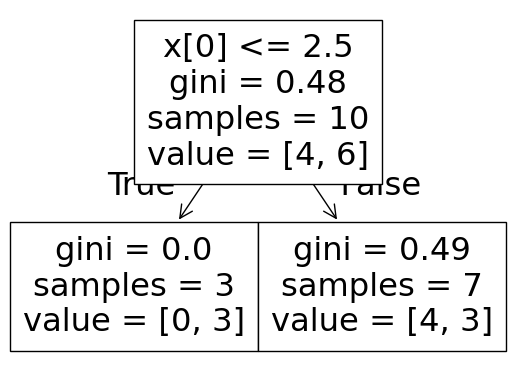

In [149]:
plot_tree(dt)

<Axes: >

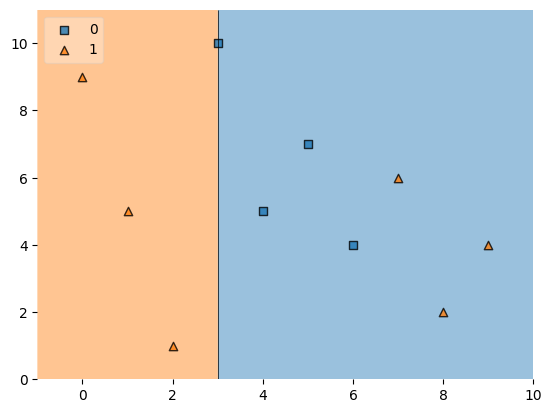

In [150]:
plot_decision_regions(X, y, dt, legend=2)

# Understanding how error and apha are playing 

In [151]:
def calculate_model_weight_alpha(error):
    #print((1-error)/(error + 0.000001))
    return 0.5 * np.log((1-error)/(error + 0.000001))

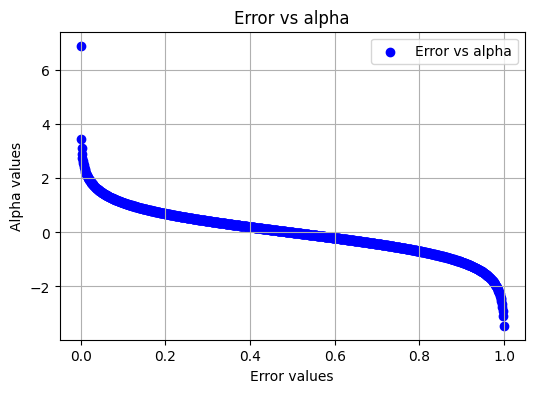

In [152]:
errors = []
alphas = []
for i in range(0, 1000):
    error = i/1000
    errors.append(error)
    alpha = calculate_model_weight_alpha(error)
    alphas.append(alpha)
    #print(f"Error {error} , alpha {alpha}")
plt.figure(figsize=(6, 4))
plt.scatter(errors, alphas, color='blue', label="Error vs alpha")  # Scatter plot of data points
#plt.plot(errors, alphas, color='red', label="Error vs alpha")  # Regression line
plt.xlabel("Error values")
plt.ylabel("Alpha values")
plt.title("Error vs alpha")
plt.legend()
plt.grid()
plt.show()

# Understanding how weights are being updated for correct and miscallsifed examples     

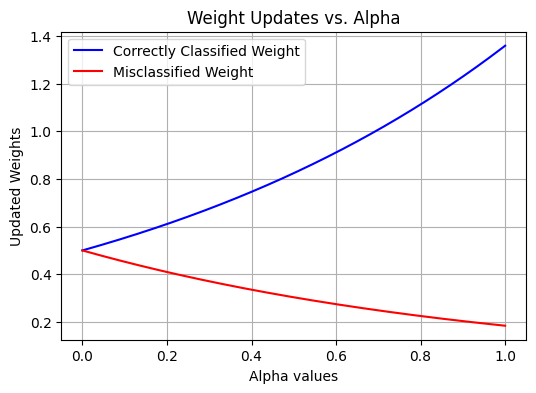

In [153]:
def get_updated_weight_pos(weight, alpha):
    """
    weight updation method correct classified exmaples
    """
    updated_weight = weight * np.exp(alpha * 1)
    return updated_weight

def get_updated_weight_neg(weight, alpha):
    """
    weight updation method miss classified exmaples
    """
    updated_weight = weight * np.exp(alpha * -1)
    return updated_weight

weight = 0.5
alphas = np.linspace(0, 1, 1000)  # Generate alpha values from 0 to 1
weights_pos = [get_updated_weight_pos(weight, alpha) for alpha in alphas]
weights_neg = [get_updated_weight_neg(weight, alpha) for alpha in alphas]

# Plot both in the same graph
plt.figure(figsize=(6, 4))
plt.plot(alphas, weights_pos, color='blue', label="Correctly Classified Weight")
plt.plot(alphas, weights_neg, color='red', label="Misclassified Weight")
plt.xlabel("Alpha values")
plt.ylabel("Updated Weights")
plt.title("Weight Updates vs. Alpha")
plt.legend()
plt.grid()
plt.show()

In [154]:
np.cumsum([1,2,3,4,5, 20])

array([ 1,  3,  6, 10, 15, 35])

In [155]:
np.searchsorted([0.1, 0.3, 0.9], [0.25, 0.11, 0.3]) # check if elements on left are within the sorted array on right

array([1, 1, 1])

# Understanding  how new indices are selected after each step based on updated weight

In [156]:
def create_new_dataset_indices(df):
    rand_values = np.random.random(len(df))  
    selected_indices = np.searchsorted(df['cumsum'].values, rand_values)  
    return selected_indices.tolist()  

In [157]:
df = pd.DataFrame()

In [158]:
df['Examples'] = range(10)
df['Normalized_weights'] = [0.1, 0.5, 0.2, 0.6, 0.3, 0.3, 0.4, 0.5, 0.9, 0.8]
df['Normalized_weights'] = df['Normalized_weights'] / df['Normalized_weights'].sum()

In [159]:
df.head()

,Examples,Normalized_weights
0,0,0.021739
1,1,0.108696
2,2,0.043478
3,3,0.130435
4,4,0.065217


In [160]:
df['cumsum'] = np.cumsum(df['Normalized_weights'])

In [161]:
df['cumsum_lower'] = df['cumsum']  - df['Normalized_weights']

In [162]:
df.head(10)

,Examples,Normalized_weights,cumsum,cumsum_lower
0,0,0.021739,0.021739,0.000000
1,1,0.108696,0.130435,0.021739
2,2,0.043478,0.173913,0.130435
3,3,0.130435,0.304348,0.173913
4,4,0.065217,0.369565,0.304348
5,5,0.065217,0.434783,0.369565
6,6,0.086957,0.521739,0.434783
7,7,0.108696,0.630435,0.521739
8,8,0.195652,0.826087,0.630435
9,9,0.173913,1.000000,0.826087


In [163]:
create_new_dataset_indices(df) # example 9 get selected more because it has more weight

[1, 9, 9, 3, 8, 9, 8, 3, 8, 8]